# Exemplo de como obter a RNA para emular FK no problema de Shallow Water 2D

In [ ]:
!apt install octave

In [ ]:
!pip install oct2py

In [ ]:
%load_ext oct2py.ipython

In [ ]:
# Baixa o código KFS2d_rna (shallow water assimilado por FK e RNA) a partir do repositório espelho do github
!git clone https://github.com/robertopsouto/kfs2d_rna_mirror.git

In [ ]:
# Entra no diretório principal do código de shalow water
%cd kfs2d_rna_mirror

/content/kfs2d_rna_mirror


In [ ]:
# Compilando o código
!make

gfortran -O2 -c -g -fopenmp ./src/kfsFunctions.f90
gfortran -O2 -c -g -fopenmp ./src/KFS2d.f90
gfortran -o ./KFS2d kfsFunctions.o KFS2d.o -llapack -lblas -g -fcheck=all -Wall -fbacktrace -fopenmp 


**Shallow Water 2D**

**DOMÍNIO 40 x 40 pontos**

**Em amarelo, os pontos usados para assimilação**

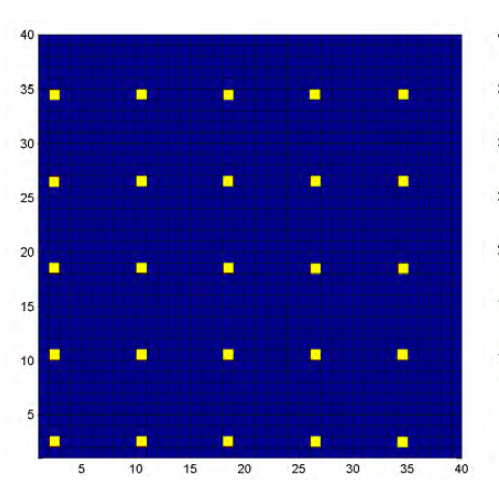

**FONTE:** FURTADO, Helaine Cristina Morais. Redes neurais para assimilaçao de dados em um modelo de circulaçao oceânica. 2012.
Tese de Doutorado. Ph. D. thesis, Instituto Nacional de Pesquisas Espaciais (INPE), São José dos Campos.

In [ ]:
# Roda o shell script que chama o executável compilado na célula anterior
# Usa filtro de Kalman para fazer a assimilação de dados a cada 10 passos no tempo.
# O ruído no dado de observação é de 10%
# Uso:
# ./run-KFS2d.sh assimType gridX gridY timeStep freqObsT freqObsX freqObsY percNoise neuronNumber

!./run-KFS2d.sh 1 10 10 200 10 2 2 0.1 10 1

In [ ]:
# Indo para o diretório com o dados que serão usados para treinar a RNA, por meio do MPCA
%cd output/training/

/content/kfs2d_rna_mirror/output/training


## Script `Octave` que normaliza os valores do modelo, da observação e da análise (obtida com a assimilação de dados). São gerados os arquivos de treinamento (`x.txt` e `y.txt`) de validação cruzada (`x_valid.txt` e `y_valid.txt`) e de generalização (`x_gen.txt` e `y_gen.txt`), que serão os dados de entrada para o `MPCA-ANN`.

In [ ]:
%%octave
qM = load('qModelExpA.out');
qO = load('qObservExpA.out');
qA = load('qAnalysisExpA.out');

valNormInf=-1.0;
valNormSup=+1.0;

qM_norm=(max(qM)*valNormInf-min(qM)*valNormSup+qM*(valNormSup-valNormInf))/(max(qM)-min(qM));
qO_norm=(max(qO)*valNormInf-min(qO)*valNormSup+qO*(valNormSup-valNormInf))/(max(qO)-min(qO));
qA_norm=(max(qA)*valNormInf-min(qA)*valNormSup+qA*(valNormSup-valNormInf))/(max(qA)-min(qA));

[l,n]=size(qM);
pontos_por_ciclo=25;

parc1 = 10*pontos_por_ciclo;
parc2 =  2*pontos_por_ciclo;
parc3 =  4*pontos_por_ciclo;

train_range=parc1;
valid_init=train_range+1;
valid_end=train_range+parc2;
gen_init=valid_end+1;
gen_end=valid_end+parc3;;

fileID = fopen('x.txt','w');
fprintf(fileID,'      %8.5f',qM_norm(1:train_range));
fprintf(fileID,'\n');
fclose(fileID);
fileID = fopen('x.txt','a');
fprintf(fileID,'      %8.5f',qO_norm(1:train_range));
fprintf(fileID,'\n');
fclose(fileID);
fileID = fopen('y.txt','w');
fprintf(fileID,'      %8.5f',qA_norm(1:train_range));
fprintf(fileID,'\n');
fclose(fileID);

fileID = fopen('x_valid.txt','w');
fprintf(fileID,'      %8.5f',qM_norm(valid_init:valid_end));
fprintf(fileID,'\n');
fclose(fileID);
fileID = fopen('x_valid.txt','a');
fprintf(fileID,'      %8.5f',qO_norm(valid_init:valid_end));
fprintf(fileID,'\n');
fclose(fileID);
fileID = fopen('y_valid.txt','w');
fprintf(fileID,'      %8.5f',qA_norm(valid_init:valid_end));
fprintf(fileID,'\n');
fclose(fileID);

fileID = fopen('x_gen.txt','w');
fprintf(fileID,'      %8.5f',qM_norm(gen_init:gen_end));
fprintf(fileID,'\n');
fclose(fileID);
fileID = fopen('x_gen.txt','a');
fprintf(fileID,'      %8.5f',qO_norm(gen_init:gen_end));
fprintf(fileID,'\n');
fclose(fileID);
fileID = fopen('y_gen.txt','w');
fprintf(fileID,'      %8.5f',qA_norm(gen_init:gen_end));
fprintf(fileID,'\n');
fclose(fileID);

In [ ]:
%octave_pull parc1
%octave_pull parc2
%octave_pull parc3

In [ ]:
parc1

250.0

In [ ]:
parc2

50.0

In [ ]:
parc3

100.0

In [ ]:
%cd ../../../

/content


In [ ]:
# Baixa o código do mpac-ann do repositório github
!git clone https://github.com/scsr-inpe/mpca-ann.git

Cloning into 'mpca-ann'...
remote: Enumerating objects: 331, done.
remote: Counting objects: 100% (149/149), done.
remote: Compressing objects: 100% (122/122), done.
remote: Total 331 (delta 63), reused 88 (delta 27), pack-reused 182
Receiving objects: 100% (331/331), 2.08 MiB | 10.76 MiB/s, done.
Resolving deltas: 100% (123/123), done.


In [ ]:
# Entra no diretório principal do código
%cd mpca-ann

/content/mpca-ann


In [ ]:
# Alterna para um commit específico
!git checkout a52ad36

Note: switching to 'a52ad36'.

You are in 'detached HEAD' state. You can look around, make experimental
changes and commit them, and you can discard any commits you make in this
state without impacting any branches by switching back to a branch.

If you want to create a new branch to retain commits you create, you may
do so (now or later) by using -c with the switch command. Example:

  git switch -c <new-branch-name>

Or undo this operation with:

  git switch -

Turn off this advice by setting config variable advice.detachedHead to false

HEAD is now at a52ad36 Delete configuration_.ini


In [ ]:
# Remove os arquivos pré-compilados que são baixados
!make clean

rm -f build/*.o *.mod
rm -rf *.*~ Makefile~ build/*.o *.mod annActivation annMLP annMPCA


In [ ]:
# Compila o código
!make

In [ ]:
# Copia os arquivos de treinamento, de validação cruzada e de generalização gerados anteriormente no k, para o diretório 'data' do mpca-ann
!cp ../kfs2d_rna_mirror/output/training/*.txt data/

In [ ]:
# Entra no diretório config, para editar os arquivos de configuração do mpca-ann
%cd config/

/content/mpca-ann/config


In [ ]:
# Edita o arquivo original configuration.ini tal que:
#    NCLASSES seja igual ao número de pontos de treinamento em x.txt e y.txt (dado pela variável parc1)
#    NCLASSESVALIDATION seja igual ao número de pontos de validação em x_valid.txt e y_valid.txt (dado pela variável parc2)
#    UPPER_HIDDEN_LAYERS=1 seja igual a LOW_HIDDEN_LAYERS=1, para forçar que a arquitetura da rede tenha somente uma camada
#    LOWER_FIRST_HIDDEN_LAYER=UPPER_FIRST_HIDDEN_LAYER=10, para forçar que esta camana tenha exatamente 10 neurônios
#    LOWER_ACTIVATION_FUNCTION=UPPER_ACTIVATION_FUNCTION=2, para forçar que se use com função de ativação a tangente hiperbólica

!sed -i -e 's/NCLASSES=2000/NCLASSES=250/g' \
        -e 's/NCLASSESVALIDATION=600/NCLASSESVALIDATION=50/g' \
        -e 's/UPPER_HIDDEN_LAYERS=2/UPPER_HIDDEN_LAYERS=1/g' \
        -e 's/LOWER_FIRST_HIDDEN_LAYER=5/LOWER_FIRST_HIDDEN_LAYER=10/g' \
        -e 's/UPPER_FIRST_HIDDEN_LAYER=25/UPPER_FIRST_HIDDEN_LAYER=10/g' \
        -e 's/LOWER_ACTIVATION_FUNCTION=1/LOWER_ACTIVATION_FUNCTION=2/g' \
        -e 's/UPPER_ACTIVATION_FUNCTION=3/UPPER_ACTIVATION_FUNCTION=2/g' \
        configuration.ini

In [ ]:
# Edita o arquivo original annConfig.ini,
# para que o número de classes seja igual ao número de pontos generalização em x_gen.txt e y_gen.txt

!sed -i -e 's/600/100/g' annConfig.in

In [ ]:
# Retorna para o diretório do script MPCA-ANN

%cd ..

/content/mpca-ann


In [ ]:
# Cria o diretório output para armazenar o resultado do mpca-ann

!mkdir output

mkdir: cannot create directory ‘output’: File exists


In [ ]:
# Roda e script com 1 Experimento, usando 1 Processo MPI

!./annMPCA 1

************************************************************

                       Experiment   1                       

************************************************************

NFE (total):                 1000 of       1000
Best objective function value: 4.2733 x (10^ -2)
Number of hidden layers:  1
Neurons in hidden layer 1: 10
Activation function:  2
Alpha: 0.4006
Eta: 0.8333
                                                            
                                                            


In [ ]:
# Roda esta etapa para obter a solução que possui o menor valor da função objetivo com relação aos dados de generalização

!./annMLP 1 1

           1
           1
         100
           2
           1
           1
           8
           0
           1
 ./output/ann1_1.out
   3.2718360000000002E-002
   4.2733409999999999E-002


In [ ]:
# Copia o arquivo ann#.best, relativo ao experimento que obteve no menor erro na etapa de generalização, para o diretório data

!cp output/ann1.best ../kfs2d_rna_mirror/data/ann.best

In [ ]:
# Entra no diretório data

%cd ../kfs2d_rna_mirror/data/

/content/kfs2d_rna_mirror/data


In [ ]:
# Roda o shell script que extrai a informação dos pesos e vies do arquivo ann.best
# São gerados 4 arquivos: wqcsExpA.dat  wqcoExpA.dat  bqcsExpA.dat  bqcoExpA.dat
# Estes 4 arquivos serão lidos pelo kfs2d, para emular o FK por RNA

!./pesos_vies.sh ann.best

In [ ]:
%cd ../

/content/kfs2d_rna_mirror


In [ ]:
# Roda o shell script que chama o executável
# Usa RNA para emular FK na assimilação de dados, a cada 10 passos no tempo.
# Uso:
# ./run-KFS2d.sh assimType gridX gridY timeStep freqObsT freqObsX freqObsY percNoise neuronNumber numthreads

!./run-KFS2d.sh 2 10 10 200 10 2 2 0.1 10 1 1

In [ ]:
# Entra no diretório onde o resultado da análise obtido com a assimilação por RNA está salvo

%cd output/full/

/content/kfs2d_rna_mirror/output/full


## Script `Octave` que gera figura comparando as curvas do modelo (verdade), da análise obtida por assimilação com filtro de Kalman (FK), e também da análise obtida por assimilação com rede neural emulando filtro de Kalman (RNA).

ans = -9.5540

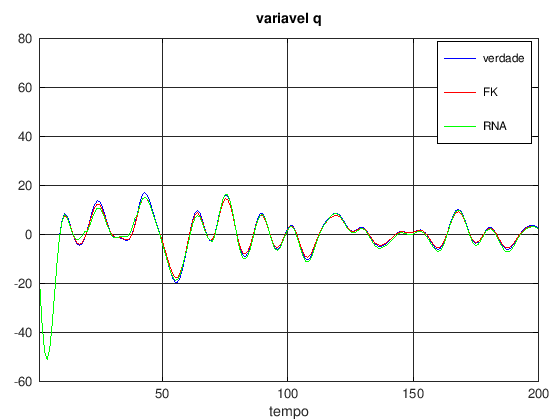

In [ ]:
%%octave

qm = load('qModelExpA.out');
qa = load('qAnalysisExpA.out');

qar = load('qAnalysisExpA_RNA.out');

ni = 5;
nj = ni;
nk = 200;

ninj = ni*nj;
p = 2; % ponto

qm3D = reshape(qm,ni,nj,nk);
qpm10 = qm3D(p,p,:);
qpm10v = qpm10(:);

qafk3D = reshape(qa,ni,nj,nk);
qpa10 = qafk3D(p,p,:);
qpa10v = qpa10(:);

qr3D = reshape(qar,ni,nj,nk);
qpr10 = qr3D(p,p,:);
qpr10v = qpr10(:);

figure(1)
plot(qpm10v,'b','linewidth',1.5); hold on;
plot(qpa10v,'r','linewidth',1.5);
plot(qpr10v,'g','linewidth',1.5);
title('variavel q'); grid on;
xlabel('tempo');
%ylabel('q');
legend('verdade','FK','RNA')
axis([1 nk -60 80])

print -dpng -r240 variavelqExpA.png;

![Variavel q](variavelqExpA.png)